In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# For reproducibility.
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Ensure plots are shown inline.
%matplotlib inline

Using device: cpu


## Data Preparation

We generate a synthetic 3-class classification dataset with 20 features, then create PyTorch DataLoaders for training and testing.

In [3]:
# Create synthetic data.
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=3,
    random_state=42,
)
# Split into train and test.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert numpy arrays to PyTorch tensors.
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders.
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = X_train.shape[1]
num_classes = 3
epochs = 10

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 800
Test samples: 200


## Model Definitions

We define three models:
- **TeacherModel:** A deep network with two hidden layers (128 neurons each).
- **StudentModel:** A smaller network with one hidden layer (32 neurons).
- **MoEModel:** A Mixture-of-Experts model that combines two small expert networks using a learned gating network.

In [ ]:
# Define model classes.


class TeacherModel(nn.Module):
    """Big teacher model with 2 hidden layers."""

    def __init__(self, input_dim, num_classes):
        super(TeacherModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


class StudentModel(nn.Module):
    """Small student model with 1 hidden layer."""

    def __init__(self, input_dim, num_classes):
        super(StudentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.out = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.out(x)


class MoEModel(nn.Module):
    """A simple Mixture-of-Experts (MoE) model.
    Two experts process the same input and a gating network learns soft weights.
    """

    def __init__(self, input_dim, num_classes, num_experts=2):
        super(MoEModel, self).__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, num_classes)
                )
                for _ in range(num_experts)
            ]
        )
        self.gate = nn.Sequential(nn.Linear(input_dim, num_experts), nn.Softmax(dim=1))

    def forward(self, x):
        expert_outputs = [
            expert(x) for expert in self.experts
        ]  # List of (batch, num_classes)
        # Stack to (batch, num_experts, num_classes).
        expert_stack = torch.stack(expert_outputs, dim=1)
        gate_weights = self.gate(x)  # (batch, num_experts)
        gate_weights = gate_weights.unsqueeze(2)  # (batch, num_experts, 1)
        output = torch.sum(expert_stack * gate_weights, dim=1)  # (batch, num_classes)
        return output


print("Models defined.")

Models defined.


## Training & Evaluation Helper Functions

We define helper functions to evaluate a model on the test data and to run a training loop for a given model.

In [5]:
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x_batch, labels in data_loader:
            x_batch, labels = x_batch.to(device), labels.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


def train_model(model, optimizer, criterion, dataloader, n_epochs):
    """Standard training loop (for teacher and MoE models)."""
    model.train()
    epoch_losses = []
    for epoch in range(n_epochs):
        running_loss = 0.0
        for x_batch, labels in dataloader:
            x_batch, labels = x_batch.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
        avg_loss = running_loss / len(dataloader.dataset)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{n_epochs}] - Loss: {avg_loss:.4f}")
    return epoch_losses

## 1. Training the Teacher (Big) Model

We train the teacher model using standard cross-entropy loss.

Training Teacher Model...
Epoch [1/10] - Loss: 0.9027
Epoch [2/10] - Loss: 0.6431
Epoch [3/10] - Loss: 0.5145
Epoch [4/10] - Loss: 0.4307
Epoch [5/10] - Loss: 0.3633
Epoch [6/10] - Loss: 0.3120
Epoch [7/10] - Loss: 0.2736
Epoch [8/10] - Loss: 0.2308
Epoch [9/10] - Loss: 0.1932
Epoch [10/10] - Loss: 0.1587
Teacher Test Accuracy: 84.00%


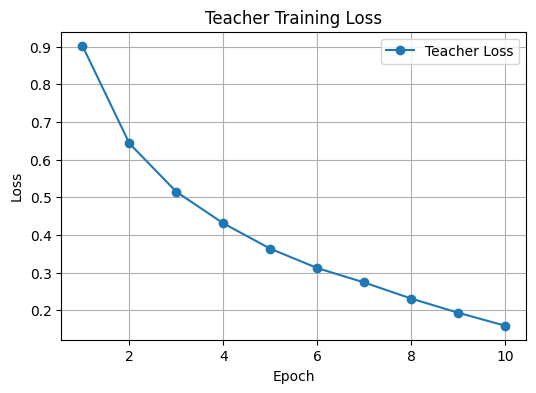

In [6]:
# Instantiate and train the teacher model.
teacher_model = TeacherModel(input_dim, num_classes).to(device)
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training Teacher Model...")
teacher_losses = train_model(
    teacher_model, optimizer_teacher, criterion, train_loader, epochs
)
teacher_test_acc = evaluate_model(teacher_model, test_loader)
print(f"Teacher Test Accuracy: {teacher_test_acc:.2%}")

# Plot teacher training loss.
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), teacher_losses, marker="o", label="Teacher Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Teacher Training Loss")
plt.legend()
plt.grid(True)
plt.show()

## 2. Training the Student Model via Knowledge Distillation

The student model is trained with a combination of:
- A hard loss (CrossEntropy on true labels)  
- A soft loss (KL divergence between the teacher's and student's predictions using temperature scaling)  

The total loss is computed as:

    Loss = α * (hard loss) + (1 - α) * T² * (soft loss)
    
where T is the temperature and α balances the two losses.

Epoch [1/10] - Student Loss: 2.0420
Epoch [2/10] - Student Loss: 1.6998
Epoch [3/10] - Student Loss: 1.4791
Epoch [4/10] - Student Loss: 1.3205
Epoch [5/10] - Student Loss: 1.1857
Epoch [6/10] - Student Loss: 1.0764
Epoch [7/10] - Student Loss: 0.9821
Epoch [8/10] - Student Loss: 0.8993
Epoch [9/10] - Student Loss: 0.8235
Epoch [10/10] - Student Loss: 0.7580
Student Test Accuracy: 73.50%


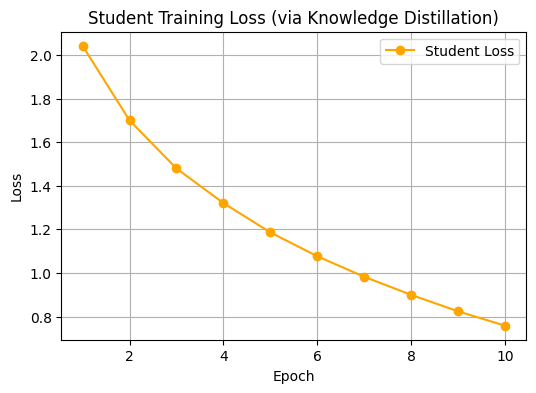

In [7]:
# Setup for Knowledge Distillation training.
temperature = 3.0
alpha = 0.5

student_model = StudentModel(input_dim, num_classes).to(device)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)
kl_loss_fn = nn.KLDivLoss(reduction="batchmean")  # for soft labels

student_losses = []
student_model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for x_batch, labels in train_loader:
        x_batch, labels = x_batch.to(device), labels.to(device)
        optimizer_student.zero_grad()
        student_logits = student_model(x_batch)
        # Hard loss.
        loss_hard = criterion(student_logits, labels)
        # Soft targets from teacher (detached so teacher is not updated).
        teacher_logits = teacher_model(x_batch).detach()
        teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
        student_log_soft = F.log_softmax(student_logits / temperature, dim=1)
        loss_soft = kl_loss_fn(student_log_soft, teacher_soft)
        # Total loss.
        loss = alpha * loss_hard + (1 - alpha) * (temperature**2) * loss_soft
        loss.backward()
        optimizer_student.step()
        running_loss += loss.item() * x_batch.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    student_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] - Student Loss: {avg_loss:.4f}")

student_test_acc = evaluate_model(student_model, test_loader)
print(f"Student Test Accuracy: {student_test_acc:.2%}")

# Plot student training loss.
plt.figure(figsize=(6, 4))
plt.plot(
    range(1, epochs + 1),
    student_losses,
    marker="o",
    color="orange",
    label="Student Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Student Training Loss (via Knowledge Distillation)")
plt.legend()
plt.grid(True)
plt.show()

## 3. Training the Small Model (Baseline) Without Knowledge Distillation

Now we train the same small network architecture using only the standard cross-entropy loss (hard labels only).  
This serves as a baseline to compare against the knowledge distillation training.

Training Small Model (Baseline) without Knowledge Distillation...
Epoch [1/10] - Loss: 0.9558
Epoch [2/10] - Loss: 0.8164
Epoch [3/10] - Loss: 0.7384
Epoch [4/10] - Loss: 0.6845
Epoch [5/10] - Loss: 0.6443
Epoch [6/10] - Loss: 0.6095
Epoch [7/10] - Loss: 0.5807
Epoch [8/10] - Loss: 0.5551
Epoch [9/10] - Loss: 0.5314
Epoch [10/10] - Loss: 0.5115
Small (Baseline) Model Test Accuracy: 72.00%


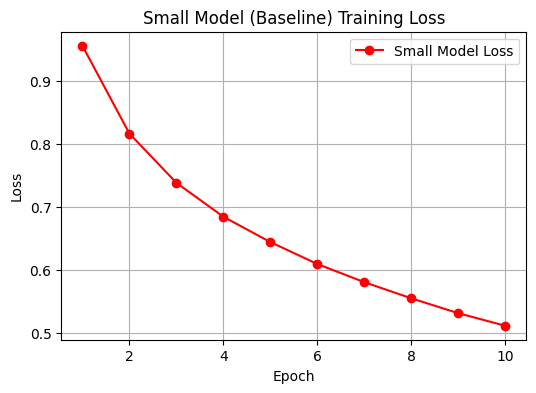

In [11]:
small_model = StudentModel(input_dim, num_classes).to(device)
optimizer_small = optim.Adam(small_model.parameters(), lr=0.001)

print("Training Small Model (Baseline) without Knowledge Distillation...")
small_losses = train_model(
    small_model, optimizer_small, criterion, train_loader, epochs
)
small_test_acc = evaluate_model(small_model, test_loader)
print(f"Small (Baseline) Model Test Accuracy: {small_test_acc:.2%}")

# Plot small model training loss.
plt.figure(figsize=(6, 4))
plt.plot(
    range(1, epochs + 1),
    small_losses,
    marker="o",
    color="red",
    label="Small Model Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Small Model (Baseline) Training Loss")
plt.legend()
plt.grid(True)
plt.show()

## 4. Training the Mixture-of-Experts (MoE) Model

The Mixture-of-Experts model consists of two expert networks (each with a small architecture) combined with a gating network.

Training Mixture-of-Experts (MoE) Model...
Epoch [1/10] - Loss: 1.1368
Epoch [2/10] - Loss: 0.8651
Epoch [3/10] - Loss: 0.7528
Epoch [4/10] - Loss: 0.6801
Epoch [5/10] - Loss: 0.6273
Epoch [6/10] - Loss: 0.5832
Epoch [7/10] - Loss: 0.5483
Epoch [8/10] - Loss: 0.5183
Epoch [9/10] - Loss: 0.4893
Epoch [10/10] - Loss: 0.4649
MoE Test Accuracy: 75.00%


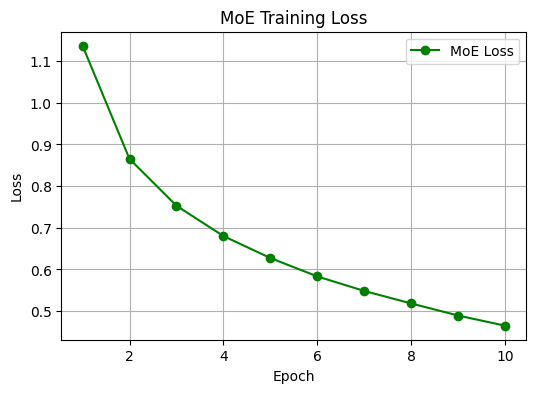

In [8]:
# Instantiate and train the Mixture-of-Experts model.
moe_model = MoEModel(input_dim, num_classes, num_experts=2).to(device)
optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001)

print("Training Mixture-of-Experts (MoE) Model...")
moe_losses = train_model(moe_model, optimizer_moe, criterion, train_loader, epochs)
moe_test_acc = evaluate_model(moe_model, test_loader)
print(f"MoE Test Accuracy: {moe_test_acc:.2%}")

# Plot MoE training loss.
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), moe_losses, marker="o", color="green", label="MoE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MoE Training Loss")
plt.legend()
plt.grid(True)
plt.show()

## Comparing Test Accuracies

The following bar chart compares the test accuracies for all the models:
- Teacher (Big) Model  
- Student (KD) Model  
- Small (Baseline) Model  
- Mixture-of-Experts (MoE) Model

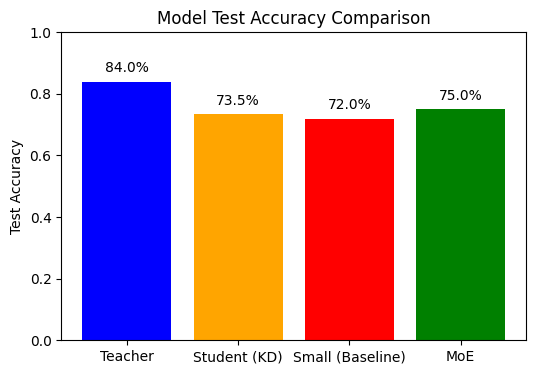

In [12]:
# Compare test accuracies.
models = ["Teacher", "Student (KD)", "Small (Baseline)", "MoE"]
accuracies = [teacher_test_acc, student_test_acc, small_test_acc, moe_test_acc]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracies, color=["blue", "orange", "red", "green"])
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Model Test Accuracy Comparison")
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval + 0.02,
        f"{acc:.1%}",
        ha="center",
        va="bottom",
    )
plt.show()

# Conclusion

This notebook demonstrated the use of:
- A comprehensive teacher model.
- Knowledge distillation to guide a smaller student model.
- A Mixture-of-Experts approach with a gating network.

Visualization of training loss curves and test accuracy comparisons helps in understanding model performance and the effect of knowledge transfer.